<h2>Tutorial QAOA</h2>

In [1]:
from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform
from pulser_simulation import QutipEmulator
import matplotlib.pyplot as plt
import numpy as np
import random
import igraph
from itertools import combinations

In [2]:
import warnings
warnings.filterwarnings('ignore')

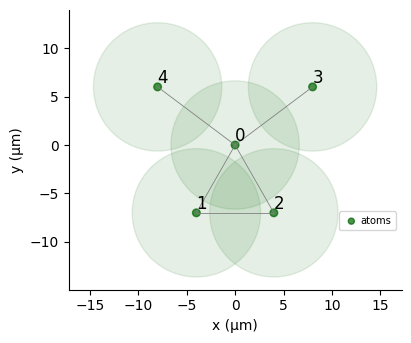

In [38]:
quibits = {
    '0':(0,0),
    '1':(-4,-7),
    '2':(4,-7),
    '3':(8,6),
    '4':(-8,6)
}
reg = Register(quibits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True
)

In [4]:
LAYERS = 2

In [5]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel('ch0','rydberg_global')

beta_list = seq.declare_variable('beta_list',size=LAYERS)
gamma_list = seq.declare_variable('gamma_list',size=LAYERS)

for beta, gamma in zip(beta_list, gamma_list):
    beta_pulse = Pulse.ConstantPulse(1000*beta, 1.0, 0.0, 0.0)
    gamma_pulse = Pulse.ConstantPulse(1000*gamma, 0.0, 1.0, 0.0)

    seq.add(beta_pulse, 'ch0')
    seq.add(gamma_pulse,'ch0')

seq.measure('ground-rydberg')

In [6]:
def quantum_loop(parameters):
    params = np.array(parameters)
    beta_params, gamma_params = np.reshape(params.astype(int), (2,LAYERS))

    assigned_seq = seq.build(beta_list=beta_params, gamma_list=gamma_params)
    sim = Simulation(assigned_seq, sampling_rate=0.01)
    res = sim.run()
    counts = res.sample_final_state(N_samples=1000)
    return counts

In [7]:
def plot_distribution(C):
    C = dict(sorted(C.items(),key=lambda item: item[1], reverse=True))
    indexes = ['01011','00111']
    color_dict = {key: 'r' if key in indexes else 'g' for key in C}
    plt.figure(figsize=(12,6))
    plt.xlabel('bitstrings')
    plt.ylabel('counts')
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation='vertical')
    plt.show()

In [8]:
# #qaoa with random params
# np.random.seed(123)

# random_beta = np.random.uniform(1,10,LAYERS)
# random_gamma = np.random.uniform(1,10,LAYERS)

# random_counts = quantum_loop(np.r_[random_beta,random_gamma])
# plot_distribution(random_counts)

In [9]:
def pos_to_graph(pos):
    rb = Chadoq2.rydberg_blockade_radius(1.0)
    g = igraph.Graph()
    N = len(pos)
    edges = [
        [m,n]
        for m,n in combinations(range(N),r=2)
        if np.linalg.norm(pos[m]-pos[n]) < rb
    ]
    g.add_vertices(N)
    g.add_edges(edges)
    return g

pos = np.array([[0.0,0.0],[-4,-7],[4,-7],[8,6],[-8,6]])
G = pos_to_graph(pos)

# calculate cost of a single configuration of the graph
def get_cost(bistring, G, penalty=10):
    z = np.array(list(bistring), dtype=int)
    A = np.array(G.get_adjacency().data)
    # add penalty and bias
    cost = penalty * (z.T @ np.triu(A) @ z) - np.sum(z)
    return cost

# weighted average over all configurations of the graph
def get_avg_cost(counts,G):
    avg_cost = sum(counts[key] * get_cost(key,G) for key in counts)
    avg_cost = avg_cost / sum(counts.values())
    return avg_cost

# cost function to minimize
def func(param, *args):
    G = args[0]
    C = quantum_loop(param)
    cost = get_avg_cost(C,G)
    return cost


In [10]:
# from scipy.optimize import minimize
# scores = []
# params = []
# for repetition in range(20):

#     random_beta = np.random.uniform(1,10,LAYERS)
#     random_gamma = np.random.uniform(1,10,LAYERS)

#     try:
#         res = minimize(
#             func,
#             args=G,
#             x0=np.r_[random_beta,random_gamma],
#             method='Nelder-Mead',
#             tol=1e-5,
#             options={'maxiter':10}
#         )
#         scores.append(res.fun)
#         params.append(res.x)
#     except Exception as e:
#         pass

c:\Users\Ilja\Documents\EPIQEK\.conda\Lib\site-packages\pulser_simulation\simulation.py:1200: DeprecationWarning: The `Simulation` class is deprecated, use `QutipEmulator.from_sequence` instead.
  warnings.warn(
c:\Users\Ilja\Documents\EPIQEK\.conda\Lib\site-packages\pulser_simulation\simulation.py:1200: DeprecationWarning: The `Simulation` class is deprecated, use `QutipEmulator.from_sequence` instead.
  warnings.warn(
c:\Users\Ilja\Documents\EPIQEK\.conda\Lib\site-packages\pulser_simulation\simulation.py:1200: DeprecationWarning: The `Simulation` class is deprecated, use `QutipEmulator.from_sequence` instead.
  warnings.warn(
c:\Users\Ilja\Documents\EPIQEK\.conda\Lib\site-packages\pulser_simulation\simulation.py:1200: DeprecationWarning: The `Simulation` class is deprecated, use `QutipEmulator.from_sequence` instead.
  warnings.warn(
c:\Users\Ilja\Documents\EPIQEK\.conda\Lib\site-packages\pulser_simulation\simulation.py:1200: DeprecationWarning: The `Simulation` class is deprecated, 

KeyboardInterrupt: 

c:\Users\Ilja\Documents\quek\.conda\Lib\site-packages\pulser_simulation\simulation.py:1200: DeprecationWarning: The `Simulation` class is deprecated, use `QutipEmulator.from_sequence` instead.
  warnings.warn(


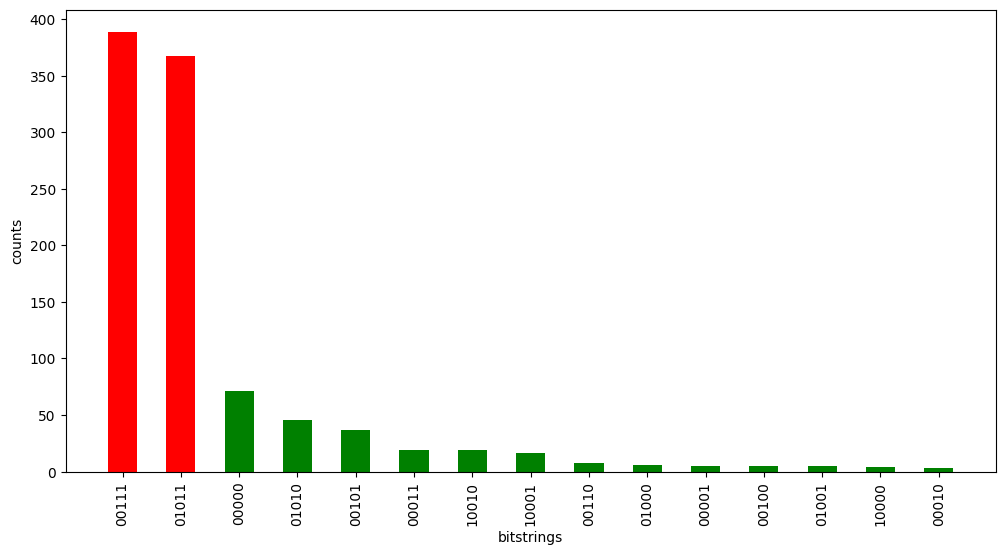

In [16]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)

<h2>QUEK</h2>

In [330]:
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pulser.devices import Chadoq2

In [391]:
# make folder structure for the dataset
for cat in ['epitopes', 'non_epitopes']:
    if not os.path.exists(os.path.join('./data',cat)):
        os.makedirs(os.path.join('./data',cat))

In [392]:
def draw_reg(reg):
    reg.draw(
        blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
        draw_graph=True,
        draw_half_radius=True
    )

In [422]:
# configure QAOA parameters
LAYERS = 5

def get_seq(coords):
    """Returns configured sequence"""
    coords = np.array(coords)
    
    reg = Register.from_coordinates(coords)
    # draw_reg(reg)
    
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel('ch0', 'rydberg_global')

    beta_list = seq.declare_variable('beta_list', size=LAYERS)
    gamma_list = seq.declare_variable('gamma_list', size=LAYERS)

    for beta, gamma in zip(beta_list, gamma_list):
        beta_pulse = Pulse.ConstantPulse(1000*beta, 1.0, 0.0, 0.0)
        gamma_pulse = Pulse.ConstantPulse(1000*gamma, 0.0, 1.0, 0.0)

        seq.add(beta_pulse, 'ch0')
        seq.add(gamma_pulse,'ch0')

    seq.measure('ground-rydberg')
    return seq

In [409]:
scaler = StandardScaler()
pca = PCA(n_components=2)


def get_closest_furthest(points):
    closest_distance = np.inf
    furthest_distance = 0

    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            distance = np.linalg.norm(np.array(points[i]) - np.array(points[j]))
            closest_distance = min(closest_distance, distance)

    for point in points:
        distance_from_origin = np.linalg.norm(point)
        furthest_distance = max(furthest_distance, distance_from_origin)

    return closest_distance, furthest_distance

def coords_are_ok(points):
    closest_distance, furthest_distance = get_closest_furthest(points)
    # print(f'Closest distance: {closest_distance}, furthest distance: {furthest_distance}')
    if closest_distance > 4 and furthest_distance < 50:
        return True
    else:
        return False

def get_features(prot):
    """Extract x,y,z, reduce dimensions. Crop protein to limit to 100 nodes"""
    prot = prot.head(100)

    prot = prot[['x','y','z']]
    prot = scaler.fit_transform(prot) # standardize
    prot = pca.fit_transform(prot)

    prot = prepare_coords(prot)
    return prot

def prepare_coords(prot):
    _,furthest_distance = get_closest_furthest(prot)
    expand_factor = 50/furthest_distance
    prot = [c*expand_factor for c in prot]
    
    #shrink one iteration
    shrink_factor = 0.99999
    prot = [c*shrink_factor for c in prot]
    # while True:
    #     prot = [c*shrink_factor for c in prot]
    #     if coords_are_ok(prot, closest_cond=False, furthest_cond=True):
    #         break

    prot = remove_close_coordinates(prot)
    assert coords_are_ok(prot)
    return prot

def remove_close_coordinates(coordinates):
    new_coordinates = coordinates.copy()
    while not coords_are_ok(new_coordinates):
        new_coordinates = remove_one_pair(new_coordinates)
                      
    return new_coordinates

def remove_one_pair(coordinates):
    for i, coord1 in enumerate(coordinates):
        for j, coord2 in enumerate(coordinates):
            if i != j:
                distance = np.linalg.norm(np.array(coord1) - np.array(coord2))
                if distance < 4:
                    coord_to_remove = random.choice([i,j])
                    coordinates.pop(coord_to_remove)
                    return coordinates

In [410]:
# load data
data = []
for cat in os.listdir('./data'):
    for i,file in enumerate(os.listdir(os.path.join('./data',cat))): 
        content = pd.read_csv(os.path.join('./data',cat, file), header=0, index_col=0)
        data.append([content,cat])


In [411]:
from tqdm import tqdm

# preproces data
D1 = []
D0 = []
for prot,label in tqdm(data):
    prot_features = get_features(prot)
    if label == 'epitopes':
        D1.append(prot_features)
    elif label  == 'non_epitopes':
        D0.append(prot_features)

Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, furthest distance: 49.9995
Closest distance: 0.796087314161099, fur

Closest distance: 4.001315519880012, furthest distance: 49.99950000000001


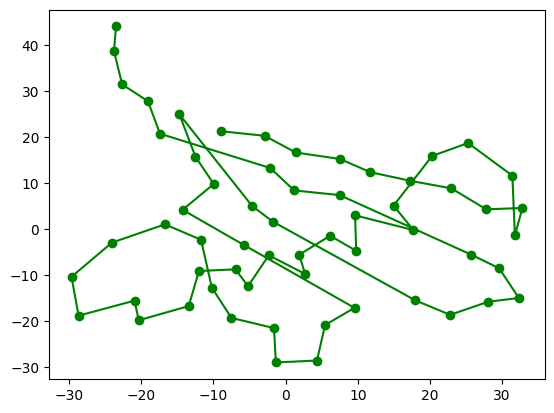

In [413]:
def plot_points(d):
    x = [el[0] for el in d]
    y = [el[1] for el in d]
    plt.plot(x,y, '-go')
    plt.show()

coords_are_ok(D1[3])
plot_points(D1[3])

In [398]:
# synthetic data
np.random.seed(123) # for reproducebility
# D0 = np.random.random((10, 5, 2))*80
# D1 = np.random.random((10, 5, 2))*80
D0 = D1[:]

# labels = np.array([1 for _ in range(10)] + [0 for _ in range(10)])
labels = np.array([1 for _ in D1] + [0 for _ in D0])

# D0 = data[:10]
# D1 = data[10:]

G0 = []
G1 = []

for gcoords,label in zip(np.concatenate((D0,D1)),labels):
    G = pos_to_graph(gcoords)
    if label == 0:
        G0.append(G)
    else:
        G1.append(G)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [414]:
def cost_function(counter0, counter1):
    """
    Calculates divergence between counter distributions
    """
    array0 = np.array(list(counter0.values()))
    array1 = np.array(list(counter1.values()))

    prob_dist0 = array0 / np.sum(array0)
    prob_dist1 = array1 / np.sum(array1)

    kl_divergence = np.sum(prob_dist0 * np.log(prob_dist0 / prob_dist1))
    return 1/kl_divergence


In [415]:
def quantum_loop(seq, parameters):
    """Applies unitary quantum evolution"""
    params = np.array(parameters)
    beta_params, gamma_params = np.reshape(params.astype(int), (2,LAYERS))

    assigned_seq = seq.build(beta_list=beta_params, gamma_list=gamma_params)
    sim = Simulation(assigned_seq, sampling_rate=0.01)
    res = sim.run()
    counts = res.sample_final_state(N_samples=1000)
    return counts

# cost function to minimize
def func(param, *args):
    D0,D1 = args[0],args[1]
    
    # run qunatum loop for every graph
    bitstrings_class_0 = []
    bitstrings_class_1 = []
    
    for data in D0:
        seq = get_seq(data)
        C = quantum_loop(seq, param) 
        bitstrings_class_0.append(C)
    for data in D1:
        seq = get_seq(data)
        C = quantum_loop(seq, param)
        bitstrings_class_1.append(C)

    cost = cost_function(bitstrings_class_0, bitstrings_class_1)
    return cost

In [423]:
from scipy.optimize import minimize
scores = []
params = []
for repetition in range(1): # try different initializations
    
    # initialize random pulse parameters
    random_beta = np.random.uniform(1,10,LAYERS)
    random_gamma = np.random.uniform(1,10,LAYERS)

    try:
        res = minimize(
            func,
            args=(D0,D1),
            x0=np.r_[random_beta,random_gamma],
            method='Nelder-Mead',
            tol=1e-5,
            options={'maxiter':10}
        )
        print(f'minimized: {res}')
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        print(e)

c:\Users\Ilja\Documents\EPIQEK\.conda\Lib\site-packages\pulser_simulation\simulation.py:1200: DeprecationWarning: The `Simulation` class is deprecated, use `QutipEmulator.from_sequence` instead.
  warnings.warn(


value too large


In [ ]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)

ValueError: attempt to get argmin of an empty sequence

## Classic ML

In [271]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score

# optimize
# from sklearnex import patch_sklearn
# patch_sklearn()

# read features todo
data = pd.read_csv('./data.csv')
X = 
y = labels

# preprocess the features
sc = StandardScaler()
X = sc.fit_transform(X)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

classifiers = [
    ('svc_linear',SVC(kernel='linear', random_state=0)),
    ('svc_poly',SVC(kernel='poly', random_state=0)),
    ('decision_tree',DecisionTreeClassifier(random_state=0)),
    ('knn',KNeighborsClassifier(n_jobs=-1)),
    ('random_forest',RandomForestClassifier(n_jobs=-1, random_state=0)),
    ('MLP',MLPClassifier(random_state=0))
]

cv_scores = []
for name, clf in classifiers:
    cv_scores.append(cross_val_score(clf, X_train, y_train, cv=5))
    print(f'clf: {name}: {cv_scores[-1]}')

print(f'Best classifier: {classifiers[cv_scores.index(max(cv_scores))]}')

SyntaxError: invalid syntax (1321390930.py, line 23)